In [53]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def display_tensor(tensor):
    image_numpy = tensor[0].squeeze().numpy()
    fig = plt.figure(figsize=(3,3))
    plt.imshow(image_numpy, cmap='gray')
    plt.axis('off')
    plt.show()    

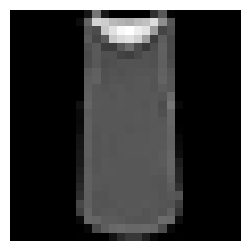

In [2]:
train_data = datasets.FashionMNIST("../data", train=True, download=True)
fig = plt.figure(figsize=(3, 3))
plt.imshow(train_data[2][0], cmap='gray')
plt.axis('off')
plt.show()

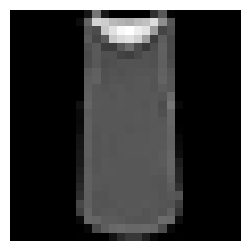

In [3]:
train_data = datasets.FashionMNIST("../data", train=True, download=True, transform=ToTensor())
image_numpy = train_data[2][0].squeeze().numpy()
fig = plt.figure(figsize=(3, 3))
plt.imshow(image_numpy, cmap='gray')
plt.axis('off')
plt.show()

In [54]:
train_data = datasets.FashionMNIST(
    root="../data", 
    train=True, 
    download=True, 
    transform=ToTensor(), 
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)
test_data = datasets.FashionMNIST(
    root="../data", 
    train=False, 
    download=True, 
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [55]:
len(train_data), len(test_data)

(60000, 10000)

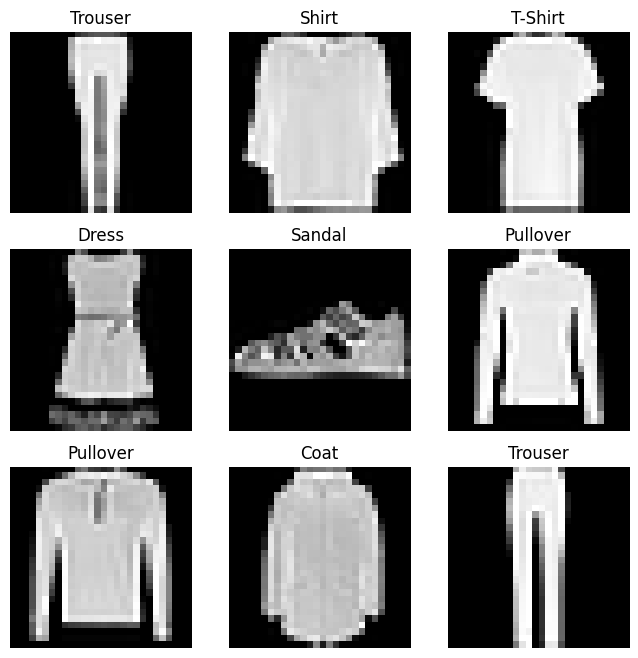

In [61]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    label_untransformed = torch.argmax(label).item()
    plt.title(labels_map[label_untransformed])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [62]:
batch_size=64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [64]:
for X, y in train_dataloader:
    print(X.shape, y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64, 10])


In [65]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [126]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [127]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [141]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [142]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [140]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.296603  [   64/60000]
loss: 0.441496  [ 6464/60000]
loss: 0.266946  [12864/60000]
loss: 0.492560  [19264/60000]
loss: 0.375201  [25664/60000]
loss: 0.410308  [32064/60000]
loss: 0.422289  [38464/60000]
loss: 0.608139  [44864/60000]
loss: 0.536476  [51264/60000]
loss: 0.382250  [57664/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.447523 

Epoch 2
-------------------------------
loss: 0.287618  [   64/60000]
loss: 0.439425  [ 6464/60000]
loss: 0.265544  [12864/60000]
loss: 0.490745  [19264/60000]
loss: 0.373767  [25664/60000]
loss: 0.408967  [32064/60000]
loss: 0.421631  [38464/60000]
loss: 0.606370  [44864/60000]
loss: 0.534914  [51264/60000]
loss: 0.381760  [57664/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.446711 

Epoch 3
-------------------------------
loss: 0.286198  [   64/60000]
loss: 0.437999  [ 6464/60000]
loss: 0.264639  [12864/60000]
loss: 0.489467  [19264/60000]
loss: 0.372295  [25664/60000]
loss: 0.407822  [32064/600

In [131]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.159867  [   64/60000]
loss: 1.168568  [ 6464/60000]
loss: 0.986829  [12864/60000]
loss: 1.124264  [19264/60000]
loss: 0.997727  [25664/60000]
loss: 1.023760  [32064/60000]
loss: 1.069972  [38464/60000]
loss: 1.000305  [44864/60000]
loss: 1.035774  [51264/60000]
loss: 0.977884  [57664/60000]
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.988149 

Epoch 2
-------------------------------
loss: 1.041685  [   64/60000]
loss: 1.070184  [ 6464/60000]
loss: 0.870639  [12864/60000]
loss: 1.030080  [19264/60000]
loss: 0.906382  [25664/60000]
loss: 0.928616  [32064/60000]
loss: 0.992950  [38464/60000]
loss: 0.925159  [44864/60000]
loss: 0.955275  [51264/60000]
loss: 0.911881  [57664/60000]
Test Error: 
 Accuracy: 67.0%, Avg loss: 0.914660 

Epoch 3
-------------------------------
loss: 0.954651  [   64/60000]
loss: 1.001321  [ 6464/60000]
loss: 0.787157  [12864/60000]
loss: 0.963463  [19264/60000]
loss: 0.844806  [25664/60000]
loss: 0.858696  [32064/600

KeyboardInterrupt: 

In [83]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [154]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

deep_model = NeuralNetwork().to(device)
print(deep_model)
loss_fn = nn.CrossEntropyLoss()
deep_optimizer = torch.optim.SGD(deep_model.parameters(), lr=1e-1)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=512, bias=True)
    (15): ReLU()
    (16): Linear(in_features=512, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [155]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, deep_model, loss_fn, deep_optimizer)
    test(test_dataloader, deep_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306765  [   64/60000]
loss: 2.306534  [ 6464/60000]
loss: 2.300381  [12864/60000]
loss: 2.305254  [19264/60000]
loss: 2.302912  [25664/60000]
loss: 2.306681  [32064/60000]
loss: 2.305102  [38464/60000]
loss: 2.301619  [44864/60000]
loss: 2.304547  [51264/60000]
loss: 2.308403  [57664/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302909 

Epoch 2
-------------------------------
loss: 2.302572  [   64/60000]
loss: 2.306072  [ 6464/60000]
loss: 2.300130  [12864/60000]
loss: 2.305027  [19264/60000]
loss: 2.302735  [25664/60000]
loss: 2.306324  [32064/60000]
loss: 2.304688  [38464/60000]
loss: 2.301164  [44864/60000]
loss: 2.303804  [51264/60000]
loss: 2.307052  [57664/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.301552 

Epoch 3
-------------------------------
loss: 2.301277  [   64/60000]
loss: 2.303847  [ 6464/60000]
loss: 2.291333  [12864/60000]
loss: 2.115259  [19264/60000]
loss: 1.594249  [25664/60000]
loss: 1.612331  [32064/600

In [158]:
# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

conv_model = ConvNeuralNetwork().to(device)
print(conv_model)
loss_fn = nn.CrossEntropyLoss()
conv_optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-3)

ConvNeuralNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [160]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, conv_model, loss_fn, conv_optimizer)
    test(test_dataloader, conv_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.383144  [   64/60000]
loss: 0.374868  [ 6464/60000]
loss: 0.255228  [12864/60000]
loss: 0.480184  [19264/60000]
loss: 0.435587  [25664/60000]
loss: 0.496247  [32064/60000]
loss: 0.464977  [38464/60000]
loss: 0.477544  [44864/60000]
loss: 0.586155  [51264/60000]
loss: 0.455852  [57664/60000]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.457844 

Epoch 2
-------------------------------
loss: 0.380831  [   64/60000]
loss: 0.372115  [ 6464/60000]
loss: 0.252053  [12864/60000]
loss: 0.477393  [19264/60000]
loss: 0.431687  [25664/60000]
loss: 0.492856  [32064/60000]
loss: 0.462793  [38464/60000]
loss: 0.475945  [44864/60000]
loss: 0.584754  [51264/60000]
loss: 0.452186  [57664/60000]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.454768 

Epoch 3
-------------------------------
loss: 0.378951  [   64/60000]
loss: 0.369502  [ 6464/60000]
loss: 0.249000  [12864/60000]
loss: 0.475023  [19264/60000]
loss: 0.428684  [25664/60000]
loss: 0.489106  [32064/600